# Clasificador paisajes
Para este ejercicio vas a crear un clasificador automático de paisajes. Los datos los encontrarás en el Classroom como `seg_train.zip` y `seg_test.zip`. Se pide:
1. Cargar las imágenes. Mira cómo están almacenados los datos. Tendrás que recorrer las carpetas, cargar las imágenes en memoria y etiquetarlas con los nombres de las carpetas. Realiza un reshape de cada imagen (comienza el ejercicio con 32x32, para ir más rápido en las ejecuciones).
2. Investiga las imágenes, comprueba con algunas muestras que has cargado bien los datos.
3. Normaliza
4. Diseña la arquitectura de la red. Recuerda que es un algiritmo de clasificación. Ojo con las dimensiones de la entrada
5. Reserva un 20% de los datos del entrenamiento para validar.
6. Representa el objeto history
7. Evalua el modelo con los datos de test
8. Representa algunos de los paisajes donde el modelo comete errores
9. Crea una matriz de confusión con los errores del modelo

**NOTA apartado 1**: para el apartado 1 tendras que recorre las carpetas/imagenes con `os.listdir()`, e ir cargando todas las imagenes como arrays de numpy

**NOTA apartado 4**: empieza con un par de capas Conv2D + MaxPooling2D con activación relu y después la fully connected layer. on softmax como ultima capa

In [46]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from pathlib import Path as Path
from skimage.io import imread
from sklearn.utils import shuffle

In [47]:
IMAGE_WIDTH = 32
IMAGE_HEIGHT = 32
IMAGE_CHANEL = 3
IMAGE_SIZE = (IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANEL)
BATCH_SIZE = 32
EPOCHS = 10

In [48]:
os.getcwd()

'c:\\Users\\ortiz\\OneDrive\\Documents\\GitHub\\DS_PT_09_2023\\Machine_Learning\\5-Deep_Learning\\2-Redes_Convolucionales\\ejercicios'

In [49]:
TRAIN_PATH = Path(r"Prof\seg_train")
TEST_PATH = Path(r"Prof\seg_test")

## Extracción de datos

In [50]:
def read_data(folder_path, im_size):
    X = []
    Y = []

    class_names = ['mountain','street','glacier', 'buildings','sea','forest']
    class_names_label = {class_name:i for i ,class_name in enumerate(class_names)}

    for category in os.listdir(folder_path):
        for file in os.listdir(os.path.join(folder_path, category)):
            filepath = os.path.join(folder_path, category, file)
            image = imread(filepath)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            smallimage = cv2.resize(image, (im_size, im_size))
            clave = class_names_label[category]
            X.append(smallimage)
            Y.append(clave)
    return np.array(X), np.array(Y) 


X_train, y_train = read_data(TRAIN_PATH, IMAGE_WIDTH)
X_test, y_test = read_data(TEST_PATH, IMAGE_WIDTH)

print(X_train.shape)
print(X_test.shape)

(14034, 32, 32, 3)
(3000, 32, 32, 3)


In [51]:
y_train

array([3, 3, 3, ..., 1, 1, 1])

## Aleatorio

In [52]:
X_train, y_train = shuffle(X_train, y_train, random_state=40)

In [53]:
y_train

array([0, 3, 3, ..., 0, 4, 4])

## Muestras

In [54]:
class_names = ['mountain','street','glacier', 'buildings','sea','forest']

sea


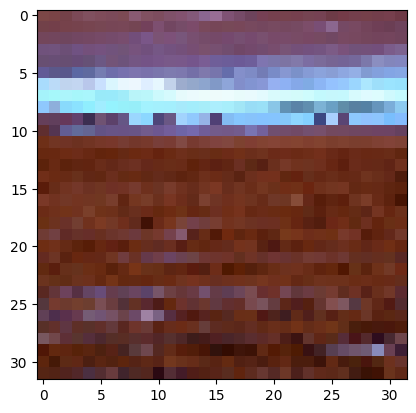

In [55]:
index = np.random.randint(X_train.shape[0])
print(class_names[y_train[index]])
plt.imshow(X_train[index]);

## Normalización

In [56]:
X_train_esc = X_train/255.0
y_train_esc = y_train/255.0

In [57]:
y_train_esc

array([0.        , 0.01176471, 0.01176471, ..., 0.        , 0.01568627,
       0.01568627])

## Diseñar la RRNN


In [66]:
from tensorflow import keras

layers = [
    keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=IMAGE_SIZE),
    keras.layers.MaxPooling2D(pool_size=(2,2)),
    
    keras.layers.Conv2D(128, (3,3), activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2,2)),
    
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(6, activation='softmax')
]

model = keras.Sequential(layers)

model.compile(optimizer = 'adam',
             loss = 'sparse_categorical_crossentropy',
             metrics = ['accuracy'])

In [67]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 30, 30, 64)        1792      
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 15, 15, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_9 (Conv2D)           (None, 13, 13, 128)       73856     
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 6, 6, 128)         0         
 g2D)                                                            
                                                                 
 flatten_4 (Flatten)         (None, 4608)              0         
                                                                 
 dense_8 (Dense)             (None, 128)              

In [68]:
from keras.callbacks import EarlyStopping
earlystop = EarlyStopping(patience=5)

In [61]:
# from keras.callbacks import ModelCheckpoint
# mcheckpoint = ModelCheckpoint("callback_model.h5")

In [69]:
from keras.callbacks import ModelCheckpoint
# mcheckpoint = ModelCheckpoint("callback_model.h5")

'''Según la documentación'''
checkpoint_filepath = '/tmp/ckpt/checkpoint.model.keras'

mcheckpoint = ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [70]:
BATCH_SIZE = 128
EPOCHS = 10

In [71]:
history = model.fit(X_train,
         y_train,
         epochs = EPOCHS,
         batch_size = BATCH_SIZE,
         callbacks = [earlystop, mcheckpoint],
         validation_split = 0.2,
         verbose=1)

Epoch 1/10
88/88 [==============================] - 7s 73ms/step - loss: 6.7265 - accuracy: 0.4320 - val_loss: 1.0640 - val_accuracy: 0.5885
Epoch 2/10
88/88 [==============================] - 5s 58ms/step - loss: 0.9541 - accuracy: 0.6271 - val_loss: 0.9429 - val_accuracy: 0.6569
Epoch 3/10
88/88 [==============================] - 5s 55ms/step - loss: 0.8394 - accuracy: 0.6794 - val_loss: 0.9013 - val_accuracy: 0.6787
Epoch 4/10
88/88 [==============================] - 5s 57ms/step - loss: 0.7797 - accuracy: 0.7111 - val_loss: 0.8804 - val_accuracy: 0.6911
Epoch 5/10
88/88 [==============================] - 5s 60ms/step - loss: 0.6834 - accuracy: 0.7460 - val_loss: 0.9878 - val_accuracy: 0.6462
Epoch 6/10
88/88 [==============================] - 5s 58ms/step - loss: 0.6243 - accuracy: 0.7669 - val_loss: 0.8310 - val_accuracy: 0.7086
Epoch 7/10
88/88 [==============================] - 5s 60ms/step - loss: 0.5644 - accuracy: 0.7913 - val_loss: 0.9145 - val_accuracy: 0.6993
Epoch 8/10
88

In [72]:
results = model.evaluate(X_test, y_test)
results

94/94 [==============================] - 1s 9ms/step - loss: 1.0169 - accuracy: 0.7037


[1.0169260501861572, 0.7036666870117188]

In [93]:
model.predict(X_test).round(0)

94/94 [==============================] - 1s 9ms/step


array([[0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       ...,
       [1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.]], dtype=float32)

In [92]:
y_test

array([3, 3, 3, ..., 1, 1, 1])

In [98]:
np.argmax(model.predict(X_test).round(0), axis=1)

94/94 [==============================] - 1s 8ms/step


array([3, 3, 3, ..., 0, 0, 1], dtype=int64)

In [100]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, np.argmax(model.predict(X_test).round(0), axis = 1))

94/94 [==============================] - 1s 8ms/step


array([[400,  10,  71,  20,  21,   3],
       [ 22, 401,   3,  53,   3,  19],
       [109,  26, 388,  13,  15,   2],
       [ 47,  99,   9, 267,   4,  11],
       [129,  19,  78,  37, 242,   5],
       [ 20,  56,   0,  15,   0, 383]], dtype=int64)

In [107]:
from sklearn.metrics import classification_report

print(classification_report(y_test, np.argmax(model.predict(X_test).round(0), axis = 1), target_names = class_names))

94/94 [==============================] - 1s 9ms/step
              precision    recall  f1-score   support

    mountain       0.55      0.76      0.64       525
      street       0.66      0.80      0.72       501
     glacier       0.71      0.70      0.70       553
   buildings       0.66      0.61      0.63       437
         sea       0.85      0.47      0.61       510
      forest       0.91      0.81      0.85       474

    accuracy                           0.69      3000
   macro avg       0.72      0.69      0.69      3000
weighted avg       0.72      0.69      0.69      3000

